In [16]:
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lib.plotting import (
    plot_bar,
    plot_hist,
)

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.width", 120)

In [17]:
data_dir_proc = 'data/processed'
clinical = pd.read_csv(Path(data_dir_proc) / 'clinical.tsv', sep='\t', index_col=0)

# describe columns 

In [18]:
# get numeric columns
clinical_num = clinical.select_dtypes(include=np.number)
print(clinical_num.shape)

(506, 25)


In [19]:
_ = clinical_num
n_missing = _.apply(lambda x: x.isna().sum())
v_counts = [_[x].value_counts() for x in _]
n_unique = pd.Series([len(x) for x in v_counts], index=n_missing.index)
# mode = pd.Series([x.index[0] for x in v_counts], index=n_missing.index)
n_mode = pd.Series([x.iloc[0] for x in v_counts], index=n_missing.index)
with pd.option_context('display.max_rows', 100):
    _ = pd.concat({
        # 'n_na': n_missing,
        'n_unique': n_unique,
        'p_na': n_missing / _.shape[0],
        'p_mode': n_mode / _.shape[0],
        'min': _.apply(lambda x: x.min()),
        'avg': _.apply(lambda x: x.mean()),
        'max': _.apply(lambda x: x.max()),
    }, axis=1)
    _ = _.sort_values('p_na')
    print(_)

                                                    n_unique      p_na    p_mode      min          avg      max
age_at_initial_pathologic_diagnosis                       51  0.019763  0.051383    38.00    65.366935    88.00
days_to_initial_pathologic_diagnosis                       1  0.019763  0.980237     0.00     0.000000     0.00
year_of_initial_pathologic_diagnosis                      23  0.019763  0.221344  1991.00  2008.395161  2013.00
tobacco_smoking_history                                    5  0.027668  0.330040     1.00     2.823171     5.00
number_pack_years_smoked                                  93  0.320158  0.069170     0.15    42.175145   154.00
shortest_dimension                                         9  0.379447  0.183794     0.10     0.379299     1.00
longest_dimension                                         30  0.379447  0.086957     0.10     1.234713     3.20
intermediate_dimension                                    19  0.379447  0.112648     0.10     0.790446  

# drop columns

In [20]:
# drop clinical columns based on the above results
max_p_na = 0.6
max_p_mode = 0.95

mask = (_['p_na'] <= max_p_na) & (_['p_mode'] <= max_p_mode)
cols_to_keep = _.index[mask]
clinical_num = clinical_num.loc[:, clinical_num.columns.isin(cols_to_keep)]
pprint(clinical_num.columns.to_list())

['age_at_initial_pathologic_diagnosis',
 'eastern_cancer_oncology_group',
 'intermediate_dimension',
 'longest_dimension',
 'number_pack_years_smoked',
 'pre_bronchodilator_fev1_percent',
 'shortest_dimension',
 'stopped_smoking_year',
 'tobacco_smoking_history',
 'year_of_initial_pathologic_diagnosis',
 'year_of_tobacco_smoking_onset']


# colinearity

In [21]:
cor_mat = clinical_num.corr()
cor_df = pd.melt(cor_mat, var_name='v2', value_name='cor', ignore_index=False)
cor_df = cor_df.reset_index(drop=False)
cor_df = cor_df.rename(columns={'index': 'v1'})
cor_df = cor_df.loc[cor_df['v1'] > cor_df['v2'], :]
cor_df['abs'] = cor_df['cor'].abs()
cor_df = cor_df.sort_values('abs', ascending=False).reset_index(drop=True)
del cor_df['abs']
cor_df.head(20)

,v1,v2,cor
0,tobacco_smoking_history,stopped_smoking_year,0.832055
1,longest_dimension,intermediate_dimension,0.683623
2,year_of_tobacco_smoking_onset,age_at_initial_pathologic_diagnosis,-0.664608
3,year_of_tobacco_smoking_onset,stopped_smoking_year,0.520674
4,stopped_smoking_year,age_at_initial_pathologic_diagnosis,-0.452438
5,year_of_tobacco_smoking_onset,year_of_initial_pathologic_diagnosis,0.327575
6,year_of_tobacco_smoking_onset,number_pack_years_smoked,-0.303838
7,shortest_dimension,longest_dimension,0.267102
8,stopped_smoking_year,number_pack_years_smoked,0.263458
9,pre_bronchodilator_fev1_percent,number_pack_years_smoked,-0.260775


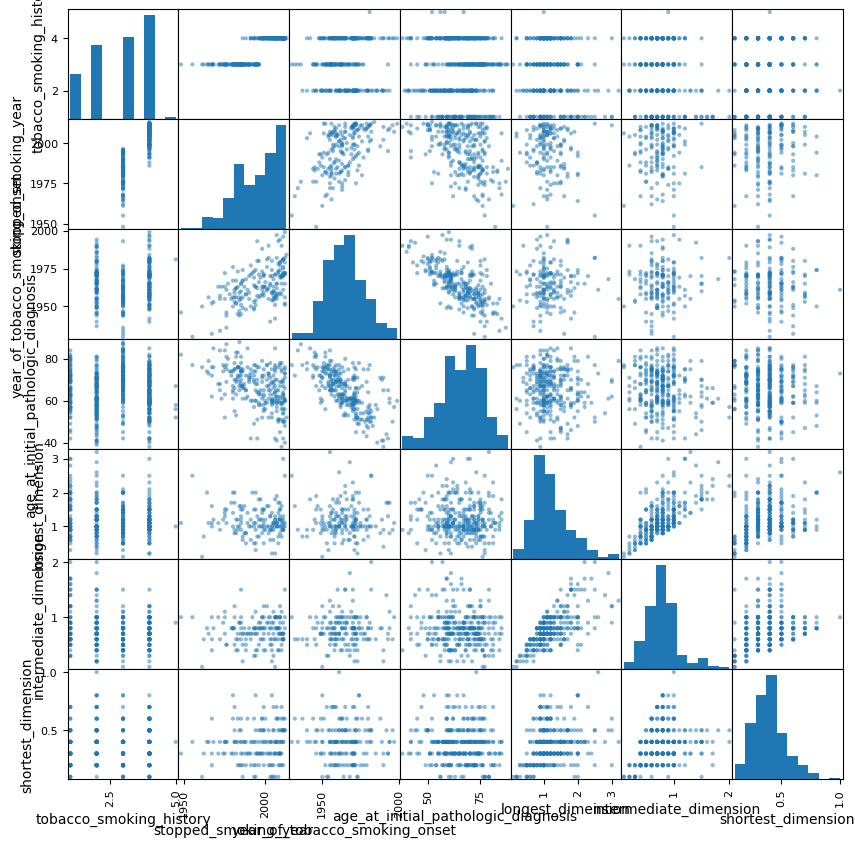

In [22]:
ax = pd.plotting.scatter_matrix(clinical_num[[
    'tobacco_smoking_history',
    'stopped_smoking_year',
    'year_of_tobacco_smoking_onset',
    'age_at_initial_pathologic_diagnosis',
    'longest_dimension',
    'intermediate_dimension',
    'shortest_dimension'
]], figsize=(10, 10))

<Axes: >

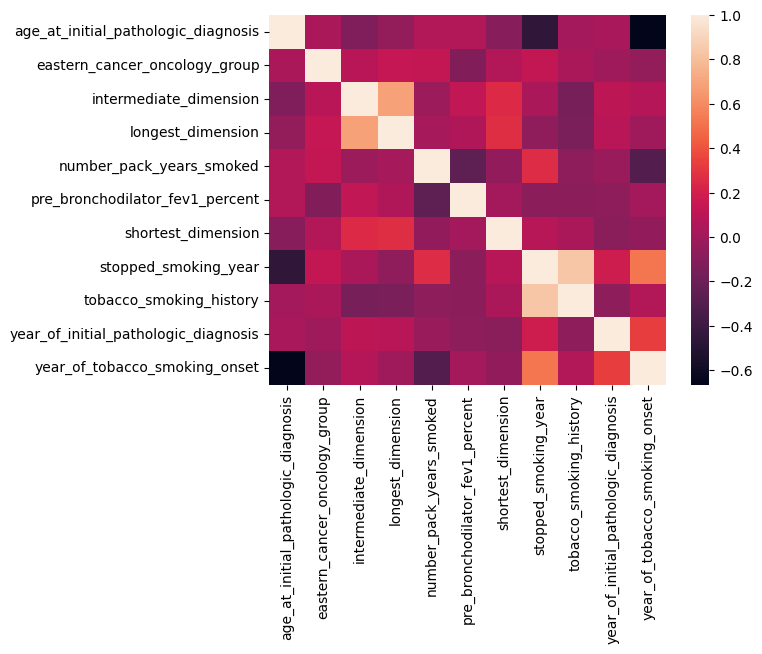

In [23]:
sns.heatmap(cor_mat)

In [ ]:
def side_by_side_plot(col1, col2, figsize=(10, 4)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    clinical_num[col1].value_counts(dropna=False).rename(col1).plot(kind='bar', ax=axes[0], subplots=True)
    clinical_num[col2].value_counts(dropna=False).rename(col2).plot(kind='bar', ax=axes[1], subplots=True)
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')

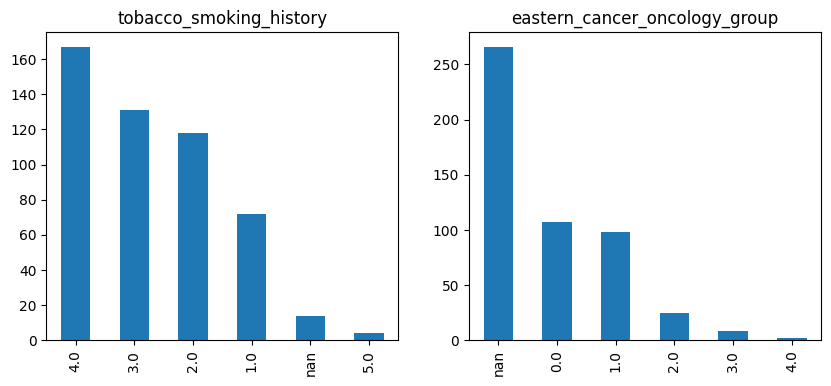

In [ ]:
# low dimension features that look categorical
side_by_side_plot('tobacco_smoking_history', 'eastern_cancer_oncology_group')

# map tobacco_smoking_history onto categorical labels:
# 1	Current smoker
# 2	Former smoker (<15 years since quitting)
# 3	Former smoker (≥15 years since quitting)
# 4	Never smoker
# 5	Smoker, unspecified / unknown type
# NaN	Missing

# apparently eastern_cancer_oncology_group (ECOG) is a strong predictor 
# - combine non-zero classes
# - treat missing as an explicit category

# feature engineering

In [26]:
# merge tumor dimension features 
clinical_num['tumour_volume'] = clinical_num['longest_dimension'] \
    * clinical_num['intermediate_dimension'] \
    * clinical_num['shortest_dimension']
del clinical_num['longest_dimension']
del clinical_num['intermediate_dimension']
del clinical_num['shortest_dimension']

In [27]:
col = 'tobacco_smoking_history'
clinical_num[col] = clinical_num[col].astype(str)\
    .replace("1.0", "1_current_smoker")\
    .replace("2.0", "2_former_smoker<15y")\
    .replace("3.0", "3_former_smoker>=15y")\
    .replace("4.0", "4_never_smoked")\
    .replace("5.0", "UNKNOWN")\
    .replace("nan", "UNKNOWN")
clinical_num[col].value_counts(dropna=False)    

tobacco_smoking_history
4_never_smoked          167
3_former_smoker>=15y    131
2_former_smoker<15y     118
1_current_smoker         72
UNKNOWN                  18
Name: count, dtype: int64

In [28]:
col = 'eastern_cancer_oncology_group'
clinical_num[col] = clinical_num[col].astype(str)\
    .replace("1.0", "1.0+")\
    .replace("2.0", "1.0+")\
    .replace("3.0", "1.0+")\
    .replace("4.0", "1.0+")\
    .replace("nan", np.nan)
clinical_num[col].value_counts(dropna=False)    

eastern_cancer_oncology_group
NaN     266
1.0+    133
0.0     107
Name: count, dtype: int64

# re-check colinearity

In [29]:
cor_mat = clinical_num.select_dtypes(include=np.number).corr()
cor_df = pd.melt(cor_mat, var_name='v2', value_name='cor', ignore_index=False)
cor_df = cor_df.reset_index(drop=False)
cor_df = cor_df.rename(columns={'index': 'v1'})
cor_df = cor_df.loc[cor_df['v1'] > cor_df['v2'], :]
cor_df['abs'] = cor_df['cor'].abs()
cor_df = cor_df.sort_values('abs', ascending=False).reset_index(drop=True)
del cor_df['abs']
cor_df.head(20)

,v1,v2,cor
0,year_of_tobacco_smoking_onset,age_at_initial_pathologic_diagnosis,-0.664608
1,year_of_tobacco_smoking_onset,stopped_smoking_year,0.520674
2,stopped_smoking_year,age_at_initial_pathologic_diagnosis,-0.452438
3,year_of_tobacco_smoking_onset,year_of_initial_pathologic_diagnosis,0.327575
4,year_of_tobacco_smoking_onset,number_pack_years_smoked,-0.303838
5,stopped_smoking_year,number_pack_years_smoked,0.263458
6,pre_bronchodilator_fev1_percent,number_pack_years_smoked,-0.260775
7,year_of_initial_pathologic_diagnosis,stopped_smoking_year,0.175192
8,tumour_volume,age_at_initial_pathologic_diagnosis,-0.133241
9,year_of_initial_pathologic_diagnosis,tumour_volume,0.117711


# write

In [30]:
clinical_num.to_csv(Path(data_dir_proc) / 'clinical_num.tsv', sep='\t')